In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from matplotlib.patches import FancyArrowPatch, ArrowStyle
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import numpy as np
import json
import os
import sys
import pickle
# %matplotlib inline


lib_path = os.path.abspath(os.path.join('..','..','Libraries'))
sys.path.append(lib_path)
Fun4all_path = os.path.abspath(os.path.join('..','..','..','..'))
sys.path.append(Fun4all_path)

from pyFunsForAll.plot_fun import colorize, adjust_lightness, get_blue_map, get_red_map
from pyFunsForAll.analy_fun import cpx_corr, fidelity, seq_cpx_corr, get_disk_mask
from pyFunsForAll.rand_fun import rnd_cpx_disk

from pyTen.decompositions import get_HOSvec, hosvd, als3herm, als4herm2
from fisher_functions import get_W3, get_W4, normalizevecs,\
    getOutputFields, fisherPerMode, fisher, get_moim, derYop
from optimize_fisher import optimize_input

In [3]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 


plt.rc('figure', facecolor='white') # white background for VSC

cmap_int = 'gray'
cmap_fish = 'inferno'
cmcra = matplotlib.cm.get_cmap('Oranges')
cmrnd = matplotlib.cm.get_cmap('Purples')
cmmod = matplotlib.cm.get_cmap('Blues')
cmmii = matplotlib.cm.get_cmap('Reds')

crnd = cmrnd(1.)#adjust_lightness('b', amount=1.2)
cmod = cmmod(0.8)#adjust_lightness('purple', amount=1.5)
ccra = cmcra(0.7)#adjust_lightness('r', amount=1.2)
cmii = cmmii(0.8)#

function = fidelity
noise = 'gaussian'


In [4]:
def get_corrVSdx(Xs, TMs, TMref, mask=None, remove_mean=False, inten=False, normalize=True):
    Ydx = getOutputFields(Xs,TMs)
    Yref = getOutputFields(Xs,TMref)
    if inten==True:
        Ydx = np.abs(Ydx)**2
        Yref = np.abs(Yref)**2
    sh = Ydx.shape
    if len(sh)==2:
        corr = seq_cpx_corr(Ydx,Yref, mask=mask, remove_mean=remove_mean, normalize=normalize)
    else:
        corr = np.empty(Ydx.shape[:2], complex)
        for i in range(Ydx.shape[1]):
            corr[:,i] = seq_cpx_corr(Ydx[:,i],Yref[i], mask=mask, remove_mean=remove_mean, normalize=normalize)
    return corr

def get_OCC(init_seeds, Hs, n_iter=200, method='als'):
    fout = 0
    W_ten = get_W3(Hs, method='2pts')
    for n, seed in enumerate(init_seeds):
        if method == 'opt':
            F, X, evol = optimize_input(
                seed, Hs, n_epochs=n_iter,lr=1e-2,noise='gaussian')
        elif method == 'als':
            us_als, evol = als3herm(
                W_ten, 1, n_iter, init_fact_mat =seed, evol=True, special_form=False)
            X = us_als[2][:,0]
            F = fisher(X, Hs, noise='gaussian')
        else:
            raise ValueError('Invalid method')
        if F>fout:
            fout = F
            xout = X
            evol_out = evol
            nseed = n
    return fout, xout, evol, nseed

def get_lim(init_seeds, Hs, n_iter=200):
    fout = 0
    for n, seed in enumerate(init_seeds):
        F, X, evol = optimize_input(
            seed, Hs, n_epochs=n_iter,lr=1e-2,noise='moim')
        
        if F>fout:
            fout = F
            xout = X
            evol_out = evol
            nseed = n

    return fout, xout, evol_out, nseed

def get_best1out(init_seeds, Hs, W4, n_iter=200):
    fout = 0
    for n, seed in enumerate(init_seeds):
        us_als, evol = als4herm2(
            W4, 1, n_iter, init_fact_mat =seed, evol=True, special_form=False)
        X = us_als[3][:,0]
        moim = get_moim(X,Hs)
        F = moim[1][1]**2
        if F>fout:
            fout = F
            xout = X
            evol_out = evol
            nseed = n
    return fout, xout, evol_out, nseed



# Load data

In [6]:

data_path = os.path.abspath(os.path.join('..','Results','SI')) 
fig_path = os.path.abspath(os.path.join('Figures','SI'))

# parameters of the aquisition
with open(os.path.join(data_path, 'param.pkl'), 'rb') as file:
        param = pickle.load(file, encoding='latin1')


TMlist4corr = np.load(os.path.join(data_path,'TM_list.npy'))
dx4corr = np.load(os.path.join(data_path,'pos_TM_list.npy'))
TMs4modes = np.load(os.path.join(data_path,'TM_3pts2computemodes.npy'))
dx4modes = np.load(os.path.join(data_path,'pos_3pts.npy'))

# load TM in the pixel basis 
TMpix = np.load(os.path.join(data_path,'TMpix.npy'))

In [425]:
dx4corr 

array([3.95015168, 3.95248365, 3.95499063, 3.95752692, 3.96000457,
       3.96251178, 3.96498942, 3.96752572, 3.9700036 , 3.97253966,
       3.97498822, 3.97749543, 3.9800024 , 3.98250937, 3.98501635,
       3.98749423, 3.99003029, 3.99250817, 3.99498606])

In [8]:
N_in = param['TMpix']['mroot']
N_out = param['TMpix']['nroot'] 
n_mod = np.shape(TMlist4corr)[-1]

# To plot output fields
def plot_field(field,ax, n_pol=1, out=True, cpx=False, **kwargs):
    if out:
        N=N_out
    else:
        N=N_in
    if n_pol ==2:
        sh = (2*N,N)
    else:
        sh = (N,N)
    if cpx:
        field2p = colorize(np.reshape(field, sh))
    else :
        field2p = np.reshape(field, sh)
    ax.axis('off')
    return ax.imshow(field2p, **kwargs)

# 1. Summary figure

## Compute crashing modes and OCC

Compute the $\mathbb W^{(3)}$ tensor, its HOSVD and identify the crahsing modes. Compute their Fisher information.

In [12]:
TMs4modes.shape

(3, 1936, 144)

In [13]:
W_ten = get_W3(TMs4modes[:2], method='2pts') # should be less susceptible to phase errors
us_hosvd, s_hosvd = hosvd(W_ten)
Xcrash = us_hosvd[2].T
Fcrash = fisher(Xcrash, TMs4modes[:2])

Compute OCC and its Fisher information

In [15]:
opt_seeds = [us_hosvd[2][:,i] for i in range(5)]
als_seeds = [[np.sum(s_hosvd[:,i,i]*us_hosvd[0],axis=-1,keepdims=True),us_hosvd[1][:,i,None],us_hosvd[2][:,i,None]]
    for i in range(5)] # iter = 80
Focc, Xocc, evol, nseed = \
    get_OCC(opt_seeds, TMs4modes[:2], n_iter=400, method='opt')

Define random inputs and fiber modes, and compute their Fisher information 

In [18]:
n_rnd = 1000
Xrnd = normalizevecs(rnd_cpx_disk((n_rnd,n_mod)))
Frnd = fisher(Xrnd, TMs4modes[:2])

Xmod = np.eye(n_mod, dtype=complex)[:n_mod]
Fmod = fisher(Xmod, TMs4modes[:2])

## 1.b Fisher information

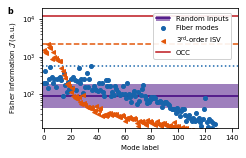

In [426]:
zf =1
fig, ax = plt.subplots(1,1, figsize=(zf*3.5,zf*2.2))
# ax2 = ax.twiny() 
ms = 4
# Random
# ln1, = ax2.plot(Frnd,'s',markersize=2, c=crnd)
ln1p = ax.fill_between(np.arange(-1,n_mod+1),np.max(Frnd), np.min(Frnd),
    facecolor=crnd,alpha=0.5)
ln1 = ax.axhline(np.mean(Frnd), linestyle='-', c=crnd)
# Fiber modes
ln2, = ax.plot(np.arange(n_mod),Fmod,'o',markersize=ms, c=cmod)
ax.axhline(np.max(Fmod), linestyle=':', c=cmod)

# Crashing modes
ln3, = ax.plot(np.arange(n_mod),Fcrash[:n_mod],'<',markersize=ms, c=ccra)
ax.axhline(np.max(Fcrash), linestyle='--', c=ccra)


# MIIS
ln4 = ax.axhline(Focc, c=cmii)

lns = [(ln1,ln1p),ln2,ln3,ln4]
lgd =ax.legend(lns,['Random inputs','Fiber modes',
    '3${}^\mathregular{rd}$-order ISV','OCC'],
    bbox_to_anchor=(.55,.55), #bbox_to_anchor=(1.8,.5), 
    # loc=0, 
    facecolor='white',framealpha=0.9)
    
ax.set_xlabel('Mode label')
# ax2.set_xlabel('Random input label')
ax.set_ylabel('Fisher information $\mathcal{J}$ (a.u.)')
ax.set_yscale('log')
ax.set_ylim(Focc *1e-3)
ax.set_xlim(-1.,n_mod-0.)
# t = ax.yaxis.get_offset_text()
# t.set_x(-10.1)
ax.text(-0.18,0.95, 'b', transform=ax.transAxes,  fontweight='bold')
plt.savefig(os.path.join(fig_path,'fish_pix.pdf'),bbox_inches='tight')

In [526]:
(Focc/np.array([np.mean(Frnd), np.max(Fmod), np.max(Fcrash), Focc]))**(1/2)

array([11.68554837,  4.75090723,  2.39837823,  1.        ])

## 1.c Intensity correlations

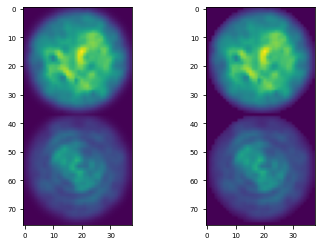

In [27]:
test_mask = getOutputFields(Xrnd[:100],TMlist4corr[0])

out_mask = get_disk_mask([N_out,N_out], 1.05*N_out//2, center=(N_out/2-1,N_out/2))
out_mask = np.concatenate((out_mask,out_mask), axis=0)
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.reshape(np.mean(np.abs(test_mask)**2,axis=0),(2*N_out,N_out)))
ax[1].imshow(out_mask*np.reshape(np.mean(np.abs(test_mask)**2,axis=0),(2*N_out,N_out)))

In [30]:
maskc = None # out_mask#
intc = True
rm=True #False
nrm=True
tm_ref = TMs4modes[1]
# The index 12 was chosen as the one giving coor=1
corr_mod = np.abs(get_corrVSdx(Xmod, TMlist4corr,tm_ref, mask=maskc,remove_mean=rm,inten=intc,normalize=nrm))
corr_crash = np.abs(get_corrVSdx(Xcrash, TMlist4corr, tm_ref, mask=maskc,remove_mean=rm,inten=intc,normalize=nrm))
corr_rnd = np.abs(get_corrVSdx(Xrnd[:], TMlist4corr, tm_ref, mask=maskc,remove_mean=rm,inten=intc,normalize=nrm))
corr_occ = np.abs(get_corrVSdx(Xocc, TMlist4corr, tm_ref, mask=maskc,remove_mean=rm,inten=intc,normalize=nrm))

<Figure size 252x158.4 with 0 Axes>

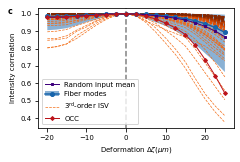

In [427]:
i0 = 0#center_TM_index-2#5#18
iref = 8
plt.figure(figsize = (3.5,2.2))
zf = 1
plt.figure(figsize = (zf*3.5,zf*2.2))
n_mod2p = n_mod#//3
n_cra2p = n_mod
ms = 4 #8
lw=0.7
dxp = (dx4corr[i0:] - dx4corr[iref])*1000



plt.gca().axvline(0, c='gray', linestyle = 'dashed')
# plt.plot(dxp, corr_crash[i0:im,0], color=cmr(n_mod2p), ls='-', label='Crashing modes')

ln3, = plt.plot(dxp, corr_crash[i0:,0], c=cmcra(0.6), ls='--', lw=lw,label='3${}^\mathregular{rd}$-order ISV')
for i in range(1,n_cra2p):
    plt.plot(dxp, corr_crash[i0:,i], c=cmcra(0.6+0.4*i/n_cra2p), ls='--', lw=lw)#cmb(n_mod2p-i-1), ls='-')
# ln3, = plt.plot(dxp, corr_crash[i0:,2], color=cmcra(0.6), ls='--', lw=lw, marker='<',markersize=ms, label='Crashing modes')
# plt.plot(dxp, np.mean(corr_crash[i0:,:], axis=-1), color=cmcra(0.6), ls='-', marker='<',markersize=8, label='Crashing modes')

# ln2, = plt.plot(dxp, corr_mod[i0:,0], color=cmmod(0.6), ls=':',label='Fiber modes')
# for i in range(1,n_mod2p):
#     plt.plot(dxp, corr_mod[i0:,i], color=cmmod(0.4+0.6*i/n_mod2p), ls=':')
ln2, = plt.plot(dxp, np.mean(corr_mod[i0:], axis=1), color=cmod, ls='-',marker='o', markersize=ms, label='Fiber modes')
ln2p = plt.fill_between(dxp, np.max(corr_mod[i0:], axis=1), np.min(corr_mod[i0:], axis=1),
    facecolor=cmod,alpha=0.5)
# plt.plot(dxp, np.mean(corr_mod[i0:,:], axis=-1), color=cmod, ls='-',marker='o', markersize=8, label='Fiber modes')

ln1, = plt.plot(dxp,np.mean(corr_rnd,axis=-1)[i0:],c=crnd,lw=1,markersize=0.6*ms,marker='s',label='Random modes')
# plt.fill_between(dxp, np.max(corr_rnd,axis=-1)[i0:], np.min(corr_rnd,axis=-1)[i0:],
#     facecolor=crnd,alpha=0.5)
ln4, = plt.plot(dxp,corr_occ[i0:],lw=1, c=cmii, markersize=0.7*ms, marker='D',label='BROAM')



all_min = plt.gca().get_ylim()[0]
plt.legend([ln1,(ln2p,ln2),ln3,ln4], ['Random input mean','Fiber modes',
    '3${}^\mathregular{rd}$-order ISV','OCC'], loc='lower left')

plt.gca().text(-0.16,0.95, 'c', transform=plt.gca().transAxes,  fontweight='bold')
plt.xlabel('Deformation $\Delta \zeta (\mu m)$')
plt.ylabel('Intensity correlation')
# plt.title('Sensitivity to perturbation')
plt.savefig(os.path.join(fig_path,'Corr_vs_def.pdf'),bbox_inches='tight')

## 1.d Output fields

In [54]:
X4est = np.load(os.path.join(data_path,'Xestimate.npy'))
# X4est =np.array([X4est[0],Xmod[np.argmax(Fmod)],Xcrash[np.argmax(Fcrash)],Xocc])
TMs4fieldplot = np.array([TMlist4corr[iref], TMlist4corr[-1]])

Yints4p = np.abs(getOutputFields(X4est[::-1], TMs4fieldplot))**2
Yints4p /= np.max(Yints4p)

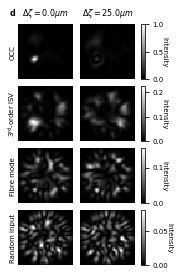

In [312]:
fig = plt.figure(figsize=(5,8))
titles = ['Random input', 'Fibre mode', '3${}^\mathregular{rd}$-order ISV', 'OCC']
"""
A grid of 2x2 images. Each row has its own colorbar.
"""
grid = AxesGrid(fig, 122,  # similar to subplot(122)
                nrows_ncols=(4, 2),
                axes_pad=0.10,
                label_mode="1",
                share_all=True,
                cbar_location="right",
                cbar_mode="edge",
                cbar_size="8%",
                cbar_pad="10%",
                )
# Z, extent = get_demo_image()
cmaps = ["spring", "winter"]
for i in range(4):
    curr_max = np.max(Yints4p[:,i])
    for j in range(2):
        ig = 2*i +j
        
        im = plot_field(Yints4p[j,i],grid[ig],vmin=0,vmax=curr_max,cmap=cmap_int,
                            interpolation='none')
        if j<1:
            # im = grid[ig].imshow(horz_reshp(Yints4p[j,i]),vmin=0,vmax=curr_max,cmap=cmap_int,
            #                 interpolation='none')
            
            grid[ig].text(-0.1,0.5, titles[-1-i],transform = grid[ig].transAxes,
                horizontalalignment='center',verticalalignment='center',fontsize=SMALL_SIZE,
                rotation=90)
        if j==1:
            # im = grid[ig].imshow(horz_reshp(Yints4p[j,i]),vmin=0,vmax=curr_max,cmap=cmap_int,
            #                 interpolation='none')
            cb = grid.cbar_axes[i].colorbar(im)#, label='Intensity')
            cb.set_label('Intensity', rotation=270)
        grid[ig].tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
for cax in grid.cbar_axes:
    cax.toggle_label(True)
    # cax.axis[cax.orientation].set_label('Foo')
grid[0].text(-0.15,1.15, 'd', transform=grid[0].transAxes,  fontweight='bold')
grid[1].text(0.5,1.2, '$\Delta \zeta =$'+str(np.round(dxp[-1],0))+'$\mu m$',transform = grid[1].transAxes,
            horizontalalignment='center',verticalalignment='center',fontsize=MEDIUM_SIZE)
grid[0].text(0.5,1.2, '$\Delta \zeta = 0.0 \mu m$',transform = grid[0].transAxes,
            horizontalalignment='center',verticalalignment='center',fontsize=MEDIUM_SIZE)

plt.savefig(os.path.join(fig_path,'fields_vs_def.pdf'),bbox_inches='tight')

# 2. Estimation figure

In [56]:
# Funciton for computing the estimation
def estimate_def(Imeas, Iref0, Ider, mui=1, mud=1, vars=None):
    if vars is None:
        vars = 1
    der = mud*Ider
    deformation = np.sum(der *(Imeas-mui * Iref0)/vars, axis=-1)/np.sum(der**2/vars, axis=-1)
    return deformation

Load the data

In [60]:
Iest_vecs = np.load(os.path.join(data_path,'Iest_vecs.npy'))
amps = np.load(os.path.join(data_path,'amps4est.npy'))
pos4est = 1000*np.load(os.path.join(data_path,'pos4est.npy'))

Compute references, derivatives and estimations

In [535]:
ind_der_pm = 3#4
ind_der_0 = 4

Irefs0 = np.mean(Iest_vecs[ind_der_0,:], axis=0) 
Idiffs_amps = (np.mean(Iest_vecs[ind_der_0+ind_der_pm,:], axis=0)-
               np.mean(Iest_vecs[ind_der_0-ind_der_pm,:], axis=0))
delx4der = pos4est[ind_der_0+ind_der_pm]-pos4est[ind_der_0-ind_der_pm]
Iders = Idiffs_amps/delx4der

int_scs = (amps**2)[:,None,None]

In [513]:
amp_cal_fields = [0,0,0,2]
def_est_int = estimate_def(Iest_vecs, Irefs0, Iders[amp_cal_fields,np.arange(4)], 
                           mui=1,mud=int_scs/int_scs[amp_cal_fields][...,0])

In [536]:
amp_ref = 2
def_est_int = estimate_def(Iest_vecs, Irefs0, Iders[amp_ref], 
                           mui=1,mud=int_scs/int_scs[amp_ref])

In [65]:
def plot_fish(fish, ax, n_pol=1, **kwargs):
    if n_pol ==2:
        sh = (2*N_out,N_out)
    else:
        sh = (N_out,N_out)
    field2p = np.reshape(fish, sh)
    ax.axis('off')
    return ax.matshow(field2p, **kwargs)

In [531]:
std_cr = 1/(int_scs[-1,0,0]/int_scs[amp_ref,0,0]*np.sqrt(np.sum((Iders[amp_ref])**2,axis=-1))/(3.87*1.0))
std_cr/std_cr[-1]

array([13.12111461,  4.37339946,  2.82642192,  1.        ])

In [508]:
std_cr = 1/(int_scs[-1,0,0]/int_scs[amp_cal_fields,0,0]*np.sqrt(np.sum((Iders[amp_cal_fields,np.arange(4)])**2,axis=-1))/(3.87*1.0))
std_cr/std_cr[-1]

array([12.69534437,  4.14505342,  2.65296203,  1.        ])

In [532]:
std_cr

array([0.4473382 , 0.14910232, 0.09636121, 0.034093  ])

In [533]:
np.mean(np.std(def_est_int[:,:,-1,:], axis=1),axis=0)

array([0.80049206, 0.17148834, 0.13964639, 0.05010466])

In [515]:
np.mean(np.std(def_est_int[:,:,-1,:], axis=1),axis=0)

array([0.43394508, 0.15973901, 0.12880205, 0.04954981])

In [524]:
std_def/std_def[-1]

array([12.22968404,  3.95855515,  2.84402549,  1.        ])

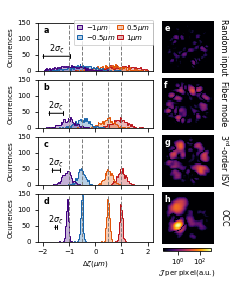

In [537]:
# Choose deformations to show
i_def_list = np.array([2,3,5,6])
ind_amp = -1#3
std_def = np.mean(np.std(def_est_int[:,:,ind_amp,:], axis=1),axis=0)


# Define scaling for Fisher plots
fmax= np.max((np.abs(Iders[amp_ref])**2).ravel())
fmin = 0.5*fmax*(10**(-4))
Iders[amp_ref][np.abs(Iders[amp_ref])==0] = fmin**(1/2)
sca_fac = Focc/np.sum(np.abs(Iders[amp_ref,3])**2)

zf = 1
colors_list= [crnd, cmod, ccra, cmii, 'teal', 'yellow']

nb_lb = [['a','b','c','d'],['e','f','g','h']]
labels = ['Random input', 'Fiber mode', '3${}^\mathregular{rd}$-order ISV', 'OCC']



fig, axs = plt.subplots(4,2,figsize=(zf*3.2,zf*4.1))
alpha = 0.3

chist = colors_list[:len(i_def_list)]
cf = []
for i in range(len(chist)):
    cf +=  [(*matplotlib.colors.to_rgb(chist[i]),alpha)]

y_lim = 150
lw=1
target_def_list = (pos4est[i_def_list]  - pos4est[4])

xmin = np.round(target_def_list[0])-1
xmax = np.round(target_def_list[-1])+1
bins = np.linspace(xmin,xmax,120)

for ip in range(4):
    
    pl_fish = plot_fish(sca_fac*(np.abs(Iders[amp_ref,ip])**2), axs[ip,1],
                        norm=colors.LogNorm(vmin=sca_fac*fmin, vmax=sca_fac*fmax),
                        cmap=cmap_fish,
                        interpolation='none')

    axs[ip,1].axis('off')
    axs[ip,1].set_ylabel(labels[ip])
    axs[ip,1].text(1.2,0.5, labels[ip],transform = axs[ip,1].transAxes,
     horizontalalignment='center', fontsize=MEDIUM_SIZE,
     verticalalignment='center', rotation=270)

    if ip<3:
        axs[ip,0].axes.xaxis.set_ticklabels([])

    axs[ip,0].set_ylim(0,y_lim)
    
    axs[3,0].set_xlabel('$\Delta \zeta (\mu m)$')
    xvar = def_est_int[i_def_list,:,ind_amp,ip].T
    axs[ip,0].hist(xvar, bins, color=chist, histtype='step',lw=lw)
    axs[ip,0].hist(xvar, bins, color=chist, alpha=alpha,  histtype='stepfilled')

    y_arrow = y_lim*0.3
    x_arrow = -1.5#target_def_list[-1]
    style = ArrowStyle('|-|',widthA=2.0,widthB=2.0)#, head_length=4, head_width=1.5)
    std_arrow = FancyArrowPatch((x_arrow-std_def[ip],y_arrow),
                                (x_arrow+std_def[ip],y_arrow),
                                shrinkA = 0, shrinkB = 0, color='black',
                                arrowstyle=style)
    axs[ip,0].add_patch(std_arrow)
    axs[ip,0].text(x_arrow,y_arrow+0.1*y_lim, r'$2\sigma_\zeta$', 
                   fontweight='bold', horizontalalignment='center')

    for n, i_def in enumerate(i_def_list):

        axs[ip,0].axvline(x=target_def_list[n], c='gray',linewidth=lw, ls='--')
    axs[ip,0].set_box_aspect(1/2.4)
    axs[ip,0].set_xticks(np.arange(xmin,xmax+1,1))
    axs[ip,0].set_ylabel('Ocurrences')

    
    axs[ip,0].text(0.05,0.8,nb_lb[0][ip], transform=axs[ip,0].transAxes, color='k', fontweight='bold')
    axs[ip,1].text(0.05,0.8,nb_lb[1][ip], transform=axs[ip,1].transAxes, color='w', fontweight='bold')

# handles = [matplotlib.patches.Rectangle((0,0),.1,.1,color=cf[i],ec=chist[i]) for i in range(4)]
# labels= ["$-1\mu m$","$-0.5\mu m$", "$0.5\mu m$",'$1\mu m$']
# fig.legend(handles, labels, fontsize=SMALL_SIZE, ncol=2, loc=(0.16,0.86), frameon=False)

cb_width =0.205
cb_height = 0.01
# cbar_ax2 = fig.add_axes([0.545, 0.9, cb_width, cb_height])
# cbar2=fig.colorbar(pl_fish, cax=cbar_ax2, orientation='horizontal', label='$\mathcal{J}$ per pixel(a.u.)')
# cbar_ax2.xaxis.set_ticks_position('top')
# cbar_ax2.get_xaxis().labelpad = -25
# cbar_ax2.xaxis.set_tick_params(pad=-2)

handles = [matplotlib.patches.Rectangle((0,0),.01,.01,color=cf[i],ec=chist[i]) for i in range(4)]
labels= ["$-1\mu m$","$-0.5\mu m$", "$0.5\mu m$",'$1\mu m$']
fig.legend(handles, labels, fontsize=SMALL_SIZE, ncol=2, loc=(0.312,0.84), 
           frameon=True, handleheight=.5,
           handlelength=.8, labelspacing=0, columnspacing=0.2,handletextpad=0.5)

cbar_ax2 = fig.add_axes([0.545, 0.1, cb_width, cb_height])
cbar2=fig.colorbar(pl_fish, cax=cbar_ax2, orientation='horizontal', label='$\mathcal{J}$ per pixel(a.u.)')
cbar_ax2.xaxis.set_ticks_position('bottom')
cbar_ax2.get_xaxis().labelpad = 0
cbar_ax2.xaxis.set_tick_params(pad=2)
plt.subplots_adjust(left=0, bottom=None, right=None, top=None, wspace=-0.2, hspace=0.1)

plt.savefig(os.path.join(fig_path,'Est_def.pdf'),bbox_inches='tight',dpi=400)

In [437]:
target_def_list

array([0.49567223])

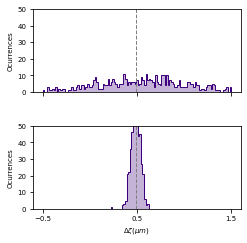

In [439]:
# Choose deformations to show
i_def_list = np.array([5])
ind_amp = -1#3
std_def = np.mean(np.std(def_est_int[:,:,ind_amp,:], axis=1),axis=0)


# Define scaling for Fisher plots
fmax= np.max((np.abs(Iders[amp_ref])**2).ravel())
fmin = 0.5*fmax*(10**(-4))
Iders[amp_ref][np.abs(Iders[amp_ref])==0] = fmin**(1/2)
sca_fac = Focc/np.sum(np.abs(Iders[amp_ref,3])**2)

zf = 1
colors_list= [crnd, cmod, ccra, cmii, 'teal', 'yellow']

nb_lb = [['a','b','c','d'],['e','f','g','h']]
labels = ['Random input', 'Fiber mode', '3${}^\mathregular{rd}$-order ISV', 'OCC']

fig, axs = plt.subplots(2,1,figsize=(zf*3.2,zf*4.1))
alpha = 0.3

chist = colors_list[:len(i_def_list)]
cf = []
for i in range(len(chist)):
    cf +=  [(*matplotlib.colors.to_rgb(chist[i]),alpha)]

y_lim = 50
lw=1
target_def_list = (pos4est[i_def_list]  - pos4est[4])

xmin = np.round(target_def_list[0],1)-1
xmax = np.round(target_def_list[-1],1)+1
bins = np.linspace(xmin,xmax,120)

for ip, ifl in enumerate(range(0,4,3)):
    
    
    if ip<1:
        axs[ip].axes.xaxis.set_ticklabels([])

    axs[ip].set_ylim(0,y_lim)
    
    
    xvar = def_est_int[i_def_list,:,ind_amp,ifl].T
    axs[ip].hist(xvar, bins, color=chist, histtype='step',lw=lw)
    axs[ip].hist(xvar, bins, color=chist, alpha=alpha,  histtype='stepfilled')

    axs[1].set_xlabel('$\Delta \zeta (\mu m)$')

    for n, i_def in enumerate(i_def_list):

        axs[ip].axvline(x=target_def_list[n], c='gray',linewidth=lw, ls='--')
    axs[ip].set_box_aspect(1/2.5)
    axs[ip].set_xticks(np.arange(xmin,xmax+1,1))
    axs[ip].set_ylabel('Ocurrences')

    

plt.subplots_adjust(left=0, bottom=None, right=None, top=None, wspace=-0.2, hspace=0.1)

# plt.savefig(os.path.join(fig_path,'Est_def_concept.pdf'),bbox_inches='tight',dpi=400)

In [436]:
xmax

1.0

In [429]:
np.arange(0,4,3)

array([0, 3])

# 3. Reaching the precision limit

Change of basis to speed things up

In [194]:
from scipy.linalg import orth

In [196]:
vecs_new_basis = np.zeros((N_out**2,n_mod*2), dtype=complex)
for i, tm in enumerate(TMs4modes[:2]):
    udef, sdef, vhdef = np.linalg.svd(tm)
    vecs_new_basis[:,n_mod*i:n_mod*(i+1)] = udef[:,:n_mod]

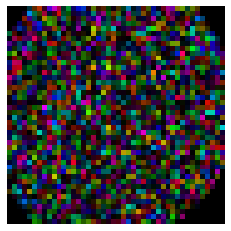

In [208]:
u_nb = orth(vecs_new_basis)
plot_field(u_nb[:,-1], plt.gca(), cpx=True)
TMs_nb= u_nb.T.conj() @ TMs4modes

Compute Fisher information in optimal output basis for random inputs and fiber modes:

In [209]:
mofish = lambda mo : np.sum(np.abs(mo[1])**2, axis=-1)

In [210]:
Fmo_rnd = []
for ind in range(n_rnd//50):
    _, vals_rnd = get_moim(Xrnd[ind*50:(ind+1)*50], TMs_nb[:2])
    Fmo_rnd += np.sum(np.abs(vals_rnd)**2, axis=-1).tolist()

MOmod = get_moim(Xmod, TMs_nb[:2])
Fmo_mod = mofish(MOmod)

Compute fourth-order crashing modes

In [211]:
W4th_tensor = get_W4(TMs_nb[:2].astype(np.csingle))
uw4s, sw4 = hosvd(W4th_tensor)
Xw4 = uw4s[3].T
MOw4 = get_moim(Xw4, TMs_nb[:2])
Fmo_w4 = mofish(MOw4)

Compute the optimal channel

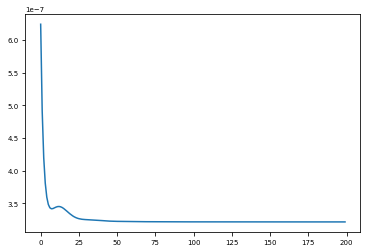

In [212]:
optw4_seeds = [Xw4[i] for i in range(10)]
Flim, Xlim, evol, nseed = get_lim(optw4_seeds, TMs_nb[:2], n_iter=200)
plt.plot(evol)

Compute optimal with single output projection

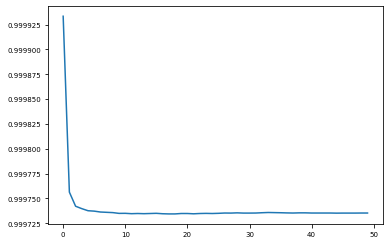

In [214]:
als4_seeds = [[uw4s[0][:,0,None],uw4s[1][:,0,None],uw4s[2][:,0,None],uw4s[3][:,0,None]]]
Fb1out, Xb1out, evol_als, nseed = get_best1out(als4_seeds, TMs_nb[:2], W4th_tensor,n_iter=50)
plt.plot(evol_als)

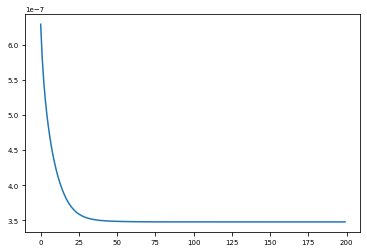

In [248]:
def get_best1out_opt(init_seeds, Hs, n_iter=200):
    fout = 0
    for n, seed in enumerate(init_seeds):
        F, X, evol = optimize_input(
            seed, Hs, n_epochs=n_iter,lr=1e-2,noise='b1o')
        
        if F>fout:
            fout = F
            xout = X
            evol_out = evol
            nseed = n

    return fout, xout, evol_out, nseed

optb1o_seeds = [Xw4[i] for i in range(10)]
Fb1o_opt, Xb1o_opt, evol, nseed = get_best1out_opt(optb1o_seeds, TMs_nb[:2], n_iter=200)
plt.plot(evol)

In [412]:
np.sum(get_moim(Xb1o_opt,TMs_nb[:2])[1]**2)

2970372.8819920616

In [413]:
np.sum(get_moim(Xlim,TMs_nb[:2])[1]**2)

3111992.025135054

## Plot figure

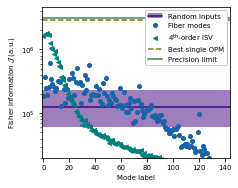

In [268]:
fig, ax1 = plt.subplots(1,1, figsize=(3.2, 2.5), layout="constrained")


# Best pix
# l0 = ax1.axhline(Focc, linestyle=':', color='gray')
# l0 = ax1.axhline(get_moim(Xlim,TMs_nb[:2])[1][1]**2, linestyle=':', color='gray')
# Random
# ln1, = ax1t.plot(Fmo_rnd,'s',markersize=2, c=crnd)
ln1p = ax1.fill_between(np.arange(-1,n_mod+1),np.max(Fmo_rnd), np.min(Fmo_rnd),
    facecolor=crnd,alpha=0.5)
ln1 = ax1.axhline(np.mean(Fmo_rnd), linestyle='-', c=crnd) 

# Fiber modes
ln2, = ax1.plot(np.arange(n_mod), Fmo_mod,'o',markersize=ms, c=cmod)
# ax.axhline(np.max(Fmo_mod), linestyle=':', c=cmod)

# best 1 out
ln3 = ax1.axhline(Fb1o_opt, c='olive', linestyle='--')

# sing W4
ln5, = ax1.plot(np.arange(n_mod), Fmo_w4,'<',markersize=ms, c='teal')
ln6 = ax1.axhline(Flim, c='seagreen')

# lns = [l0,(ln1p,ln1),ln2,ln3,ln5,ln6]
lns = [(ln1p,ln1),ln2,ln5,ln3,ln6]
lgd =ax1.legend(lns,[#'Best pixel',
    'Random inputs','Fiber modes',
    '4${}^\mathregular{th}$-order ISV','Best single OPM','Precision limit'],
    # bbox_to_anchor=(1.,.5), #bbox_to_anchor=(1.8,.5), 
    loc=0, facecolor='white',framealpha=1)
    
ax1.set_xlabel('Mode label')
# ax1.set_xlabel('Random input label')
ax1.set_ylabel('Fisher information $\mathcal{J}$ (a.u.)')
ax1.set_yscale('log')
ax1.set_xlim(-1.,n_mod-0.)

ax1.set_ylim(2e4,Flim*1.5)
# ax1.text(-0.18,0.95, nb_lb[0], transform=ax1.transAxes,  fontweight='bold')
plt.savefig(os.path.join(fig_path,'Precision_lim.pdf'),bbox_inches='tight',dpi=400)

# 4. Comparing fields close to the limit

Compute fields

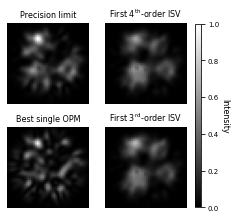

In [303]:
Ysbest = np.abs(getOutputFields(np.array([Xlim,Xw4[0],Xb1o_opt,Xcrash[0]]), TMs4modes[1]))**2
Ysbest /= np.max(Ysbest)
fig, axs = plt.subplots(2,2,figsize=(3.2,1.1*3.2))
titles = ['Precision limit', 'First 4${}^\mathregular{th}$-order ISV', 
    'Best single OPM','First 3${}^\mathregular{rd}$-order ISV']
for i, ax in enumerate(axs.ravel()):
    ax.set_title(titles[i], fontsize=MEDIUM_SIZE)
    # pl_int = ax.imshow(horz_reshp(Ysbest[i]),cmap=cmap_int, vmin=0,vmax=1)
    pl_int = plot_field(Ysbest[i], ax, cmap=cmap_int, vmin=0,vmax=1)
    ax.axis('off')

cb_width =0.025
cb_height = 0.725
cbar_ax2 = fig.add_axes([0.94, 0.14, cb_width, cb_height])
cbar2=fig.colorbar(pl_int, cax=cbar_ax2, orientation='vertical')#, label='Intensity')
cbar2.set_label('Intensity', rotation=270, fontsize=MEDIUM_SIZE)
cbar_ax2.get_yaxis().labelpad = 10
# cbar_ax2.yaxis.set_ticks_position('left')
plt.savefig(os.path.join(fig_path,'field_comp.pdf'),bbox_inches='tight',dpi=400)

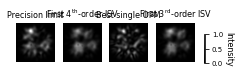

In [551]:
Ysbest = np.abs(getOutputFields(np.array([Xlim,Xw4[0],Xb1o_opt,Xcrash[0]]), TMs4modes[1]))**2
Ysbest /= np.max(Ysbest)
fig, axs = plt.subplots(1,4,figsize=(3.2,0.3*3.2))
titles = ['Precision limit', 'First 4${}^\mathregular{th}$-order ISV', 
    'Best single OPM','First 3${}^\mathregular{rd}$-order ISV']
for i, ax in enumerate(axs.ravel()):
    ax.set_title(titles[i], fontsize=MEDIUM_SIZE)
    # pl_int = ax.imshow(horz_reshp(Ysbest[i]),cmap=cmap_int, vmin=0,vmax=1)
    pl_int = plot_field(Ysbest[i], ax, cmap=cmap_int, vmin=0,vmax=1)
    ax.axis('off')

cb_width =0.005
cb_height = 0.425
cbar_ax2 = fig.add_axes([0.94, 0.2, cb_width, cb_height])
cbar2=fig.colorbar(pl_int, cax=cbar_ax2, orientation='vertical')#, label='Intensity')
cbar2.set_label('Intensity', rotation=270, fontsize=MEDIUM_SIZE)
cbar_ax2.get_yaxis().labelpad = 10
# cbar_ax2.yaxis.set_ticks_position('left')
# plt.savefig(os.path.join(fig_path,'field_comp.pdf'),bbox_inches='tight',dpi=400)

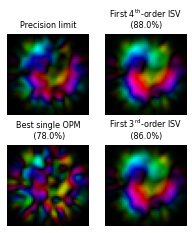

In [424]:
Ysbest = getOutputFields(np.array([Xlim,Xw4[0],Xb1o_opt,Xcrash[0]]), TMs4modes[1])
Ysbest /= np.max(Ysbest)
fig, axs = plt.subplots(2,2,figsize=(3.2,1.1*3.4))
titles = ['Precision limit', 'First 4${}^\mathregular{th}$-order ISV', 
    'Best single OPM','First 3${}^\mathregular{rd}$-order ISV']
for i, ax in enumerate(axs.ravel()):
    corr = seq_cpx_corr(Ysbest[i],Ysbest[0])
    if i>0:
        ax.set_title(titles[i]+'\n ('+str(np.round(np.abs(corr)*100,0))+'%)', fontsize=MEDIUM_SIZE)
    else:
        ax.set_title(titles[i], fontsize=MEDIUM_SIZE)
    pl_int = plot_field(np.exp(-1j*np.angle(corr))*Ysbest[i], ax, cpx=True)
    ax.axis('off')

# cbar_ax2.yaxis.set_ticks_position('left')
plt.savefig(os.path.join(fig_path,'field_comp_cpx.pdf'),bbox_inches='tight',dpi=400)

In [417]:
seq_cpx_corr(Ysbest,Ysbest[0])

array([ 1.        +0.j        ,  0.87321379+0.08033437j,
        0.62953766+0.45805843j, -0.84066806+0.18010977j])

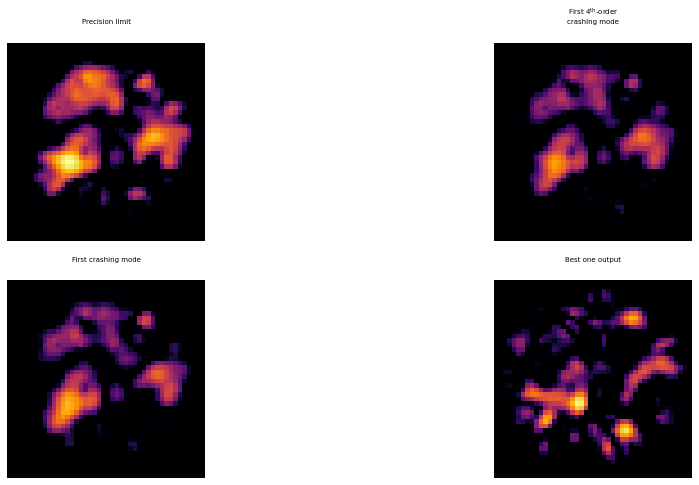

In [259]:
Ysbest = fisherPerMode(np.array([Xlim,Xw4[0],Xcrash[0],Xb1o_opt]), TMs4modes[::2])
Ysbest /= np.max(Ysbest)
Ysbest[Ysbest<=0]=10e-9
fig, axs = plt.subplots(2,2,figsize=5*np.array([3.2,0.5*3.2]))
titles = ['Precision limit', 'First 4${}^\mathregular{th}$-order\ncrashing mode', 
    'First crashing mode','Best one output']
for i, ax in enumerate(axs.ravel()):
    ax.set_title(titles[i])
    plot_fish(Ysbest[i], ax,
                norm=colors.LogNorm(vmin=10e-3, vmax=1),
                                    cmap=cmap_fish,
                                    interpolation='none')
    ax.axis('off')

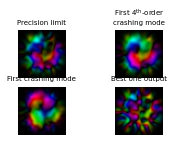

In [260]:
Ysbest =getOutputFields(np.array([Xlim,Xw4[0],Xcrash[0],Xb1o_opt]), TMs4modes[1])
Ysbest /= np.max(np.abs(Ysbest))
fig, axs = plt.subplots(2,2,figsize=(3.2,0.6*3.2))
titles = ['Precision limit', 'First 4${}^\mathregular{th}$-order\ncrashing mode', 
    'First crashing mode','Best one output']
for i, ax in enumerate(axs.ravel()):
    ax.set_title(titles[i])
    plot_field(Ysbest[i], ax, cpx=True)


In [261]:
np.abs(seq_cpx_corr(Ysbest,Ysbest[0]))

array([1.        , 0.87690132, 0.85974549, 0.77854684])

In [298]:
Ys_rnd  = getOutputFields(np.array(Xrnd), TMs4modes[1])
Ys_rnd /= np.max(np.abs(Ys_rnd))
np.mean(np.abs(seq_cpx_corr(Ys_rnd,Ysbest[0])))

0.1218698028584042

In [299]:
np.abs(seq_cpx_corr(Ys_rnd[:20],Ysbest[0]))

array([0.09280933, 0.05573902, 0.06928105, 0.11076922, 0.13155375,
       0.20912272, 0.13849386, 0.10058687, 0.11774188, 0.15038513,
       0.11998876, 0.19395487, 0.07805028, 0.06433818, 0.12836155,
       0.0479367 , 0.14978806, 0.13332765, 0.11887908, 0.18864922])

# 5. Blind estimation

In [315]:
udef, sdef, vhdef = np.linalg.svd(TMpix)
TMs_modes = udef[:,:n_mod].T.conj() @ TMs4modes[:2]

n_moims = n_mod
sing_moims = uw4s[0][:,:n_moims]/(np.sum(np.abs(uw4s[0][:,:n_moims])**2,axis=0, keepdims=True))**(1/2)
TMs_hosvd = sing_moims.T.conj() @ TMs_nb[:2]

In [316]:
# n_rnd = 10000
# Xrnd = normalizevecs(rnd_cpx_disk((n_rnd,n_mod)))
Frnd_pix = fisher(Xrnd, TMs4modes[:2], noise=noise)
Frnd_mod = fisherPerMode(Xrnd, TMs_modes, noise=noise)
# Frnd_svd = fisherPerMode(Xrnd, TMs_svd, noise=noise)
Frnd_hosvd = fisherPerMode(Xrnd, TMs_hosvd, noise=noise)

In [318]:
Frnd_pix.min()

41.949627621187894

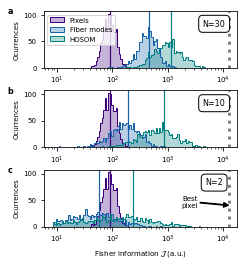

In [329]:
nb_lb = ['a','b','c','d']
Fsrnd = np.array([Frnd_mod, Frnd_hosvd])
lwvl=3
zf=1
lbs = ['Pixels', 'Fiber modes', 'HOSOM']
chist = [crnd, cmod, 'teal', cmii]#ccra, cmii]
bins = np.geomspace(0.2*Frnd_pix.min(), Fsrnd.ravel().max(), 100)
alpha = 0.3
lw=1

fig, axs = plt.subplots(3,1,figsize=(zf*3.15,zf*3.5))

for ind_p, n_outs in enumerate([30, 10, 2]):
    for i, d in enumerate([Frnd_pix, Frnd_mod, Frnd_hosvd]):
        if i != 0:
            vals_sort = np.argsort(np.mean(d, axis=0))
            dh=np.sum(d[:,vals_sort[-n_outs:]],axis=-1)
        else:
            dh=d
        axs[ind_p].hist(dh, bins, color=chist[i], histtype='step',lw=lw)
        axs[ind_p].hist(dh, bins, color=chist[i], alpha=alpha,  histtype='stepfilled')
            
        axs[ind_p].axvline(x=np.mean(dh), c=chist[i],linewidth=1.2*lw)

    axs[ind_p].set_xscale('log')
    axs[ind_p].axvline(x=Focc, c='gray',linestyle=':',linewidth=lwvl)
    axs[ind_p].set_ylabel('Ocurrences')
    
    axs[ind_p].text(-0.19,0.95,nb_lb[ind_p], transform=axs[ind_p].transAxes, fontweight='bold')
    axs[ind_p].text(0.88,0.73,'N='+str(n_outs), fontsize=MEDIUM_SIZE, 
        horizontalalignment='center', transform = axs[ind_p].transAxes,
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
cf = []
for i in range(3):
    cf +=  [(*matplotlib.colors.to_rgb(chist[i]),alpha)]
handles = [matplotlib.patches.Rectangle((0,0),.1,.1,color=cf[i],ec=chist[i]) for i in range(3)]
axs[0].legend(handles, lbs, fontsize=SMALL_SIZE, ncol=1, loc='upper left')#, frameon=False)
axs[2].annotate('Best\npixel', xy=(Focc, 40), xytext=(Focc*0.2, 35), horizontalalignment='center',
            fontsize=SMALL_SIZE, arrowprops=dict(facecolor='black',width=0.8,headlength=5,headwidth=5))
# axs[2].annotate('Best\npixel', xy=(Focc, 300), xytext=(40, 650), horizontalalignment='left',
#             fontsize=SMALL_SIZE, arrowprops=dict(facecolor='black',width=0.8,headlength=5,headwidth=5))
axs[2].set_xlabel('Fisher information $\mathcal{J}$ (a.u.)')

plt.tight_layout(pad=0., w_pad=0., h_pad=.02)
plt.savefig(os.path.join(fig_path,'Best_out_basis.pdf'),bbox_inches='tight')

# Suplementary Figures

## S1. Choosing the input modes: SVD at rest

In [7]:
# load TM in the pixel basis 
TMpix = np.load(os.path.join(data_path,'TMpix.npy'))

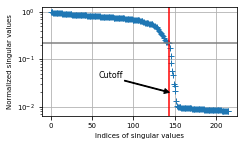

In [335]:
u, s, vh = np.linalg.svd(TMpix)
fig,ax = plt.subplots(1, 1,figsize=(3.5,2))
ax.semilogy((s[:int(n_mod*1.5)]/s[0]),'+')
ax.axvline(n_mod-.5,c='r')
ax.axhline((s[n_mod-1]/s[0]),c='gray')
ax.grid(True)
ax.set_xlabel('Indices of singular values')
# ax2.set_xlabel('Random input label')
ax.set_ylabel('Normalized singular values')
ax.annotate('Cutoff', xy=(n_mod-.5,2e-2), xytext=(n_mod/2, 4e-2), horizontalalignment='center',
            fontsize=MEDIUM_SIZE, arrowprops=dict(facecolor='black',width=0.8,headlength=5,headwidth=5))

fig.savefig(os.path.join(fig_path,'svd_pix.pdf'),bbox_inches='tight')

## S3. Unnormalized correlation curves

In [336]:
def get_IchgVSdx(Xs, TMs, TMref, mask=None, remove_mean=False):
    Ydx = getOutputFields(Xs,TMs)
    Yref = getOutputFields(Xs,TMref)
    
    Ydx = np.abs(Ydx)**2
    Yref = np.abs(Yref)**2
    sh = Ydx.shape

    chg = np.sum((Yref-Ydx)**2, axis=-1)
    
    return chg

In [338]:
chg_mod = get_IchgVSdx(Xmod, TMlist4corr,tm_ref)
chg_crash = get_IchgVSdx(Xcrash, TMlist4corr, tm_ref)
chg_rnd = get_IchgVSdx(Xrnd, TMlist4corr, tm_ref)
chg_occ = get_IchgVSdx(Xocc, TMlist4corr, tm_ref)

<Figure size 252x158.4 with 0 Axes>

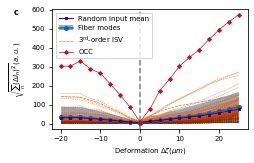

In [342]:
i0 = 0#center_TM_index-2#5#18
iref = 8
plt.figure(figsize = (3.5,2.2))
zf = 1
plt.figure(figsize = (zf*3.5,zf*2.2))
n_mod2p = n_mod#//3
n_cra2p = n_mod
ms = zf*4 #8
lw=zf*0.7
dxp = (dx4corr[i0:] - dx4corr[iref])*1000

fun_scale = lambda x : x**(1/2) 

plt.gca().axvline(0, c='gray', linestyle = 'dashed')
# plt.plot(dxp, corr_crash[i0:im,0], color=cmr(n_mod2p), ls='-', label='Crashing modes')

ln3, = plt.plot(dxp, fun_scale(chg_crash[i0:,0]), c=cmcra(0.6), ls='--', lw=lw,label='Crashing modes')
for i in range(1,n_cra2p):
    plt.plot(dxp, fun_scale(chg_crash[i0:,i]), c=cmcra(0.6+0.4*i/n_cra2p), ls='--', lw=0.6*lw)#cmb(n_mod2p-i-1), ls='-')
# ln3, = plt.plot(dxp, corr_crash[i0:,2], color=cmcra(0.6), ls='--', lw=lw, marker='<',markersize=ms, label='Crashing modes')
# plt.plot(dxp, np.mean(corr_crash[i0:,:], axis=-1), color=cmcra(0.6), ls='-', marker='<',markersize=8, label='Crashing modes')

# ln2, = plt.plot(dxp, corr_mod[i0:,0], color=cmmod(0.6), ls=':',label='Fiber modes')
# for i in range(1,n_mod2p):
#     plt.plot(dxp, corr_mod[i0:,i], color=cmmod(0.4+0.6*i/n_mod2p), ls=':')
ln2, = plt.plot(dxp, fun_scale(np.mean(chg_mod[i0:], axis=1)), color=cmod, ls='-',marker='o', markersize=ms, label='Fiber modes')
ln2p = plt.fill_between(dxp, fun_scale(np.max(chg_mod[i0:], axis=1)), fun_scale(np.min(chg_mod[i0:], axis=1)),
    facecolor=cmod,alpha=0.5)
# plt.plot(dxp, np.mean(corr_mod[i0:,:], axis=-1), color=cmod, ls='-',marker='o', markersize=8, label='Fiber modes')

ln1, = plt.plot(dxp,fun_scale(np.mean(chg_rnd,axis=-1)[i0:]),c=crnd,lw=1,markersize=0.6*ms,marker='s',label='Random modes')
# plt.fill_between(dxp, fun_scale(np.max(chg_rnd,axis=-1)[i0:]), fun_scale(np.min(chg_rnd,axis=-1)[i0:]),
#     facecolor=crnd,alpha=0.5)
ln4, = plt.plot(dxp,fun_scale(chg_occ[i0:]),lw=lw, c=cmii, markersize=0.7*ms, marker='D',label='BROAM')



all_min = plt.gca().get_ylim()[0]
plt.legend([ln1,(ln2p,ln2),ln3,ln4], ['Random input mean','Fiber modes',
    '3${}^\mathregular{rd}$-order ISV','OCC'], loc='upper left')

plt.gca().text(-0.2,0.95, 'c', transform=plt.gca().transAxes,  fontweight='bold')
plt.xlabel('Deformation $\Delta \zeta (\mu m)$')
plt.ylabel('$\sqrt{\sum_n (\Delta I_n)^2}  (a.u.)$ ')
# plt.gca().set_yscale('log')
# plt.title('Sensitivity to perturbation')
plt.savefig(os.path.join(fig_path,'Ichg_vs_def.pdf'),bbox_inches='tight')

## S. Camera background for reference during estimation

3.870485538457524

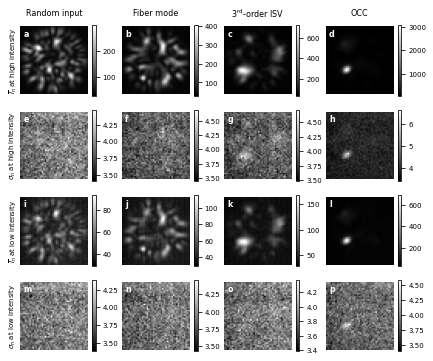

In [543]:
zf=1
ind_def= 4
ind_amp = 2
ind_amp2 = -1
meansI = np.mean(Iest_vecs, axis=1)
stdI = np.std(Iest_vecs, axis=1)
fig, axs = plt.subplots(4,4, figsize=(zf*7.,zf*6))
nb_lb = [['a','b','c','d'],['e','f','g','h'],['i','j','k','l']
,['m','n','o','p']]
# ylbls = ['$\overline{I}_n$ at 100%','$\sigma_n$ at 100%','$\overline{I}_n$ at 4%','$\sigma_n$ at 4%']
ylbls = ['$\overline{I}_n$ at high intensity','$\sigma_n$ at high intensity',
         '$\overline{I}_n$ at low intensity','$\sigma_n$ at low intensity']

labels = ['Random input', 'Fiber mode', '3${}^\mathregular{rd}$-order ISV', 'OCC']

vmax_nll= np.max(stdI[ind_def,ind_amp2,:])
vmin_nll= np.min(stdI[ind_def,ind_amp2,:])
vmax_nhl= np.max(stdI[ind_def,ind_amp,:])
vmin_nhl= np.min(stdI[ind_def,ind_amp,:])
for ind_f in range(4):
    # intp = axs[0,ind_f].imshow(horz_reshp(meansI[ind_def,ind_amp,ind_f]),
    #                     cmap=cmap_int,vmin=0)
    intp = plot_field(meansI[ind_def,ind_amp,ind_f], axs[0,ind_f],
                      cmap=cmap_int)#,vmin=0)
    
    stdp = plot_field(stdI[ind_def,ind_amp,ind_f], axs[1,ind_f],
                      cmap=cmap_int)#,vmin=vmin_nhl,vmax=vmax_nhl)
    
    fig.colorbar(intp, ax= axs[0,ind_f])
    fig.colorbar(stdp, ax= axs[1,ind_f])

    intp = plot_field(meansI[ind_def,ind_amp2,ind_f], axs[2,ind_f],
                      cmap=cmap_int)
    stdp = plot_field(stdI[ind_def,ind_amp2,ind_f], axs[3,ind_f],
                      cmap=cmap_int)#,vmin=vmin_nll,vmax=vmax_nll)
    
    fig.colorbar(intp, ax= axs[2,ind_f])
    fig.colorbar(stdp, ax= axs[3,ind_f])
    

    
    axs[0,ind_f].text(0.5,1.2, labels[ind_f],transform = axs[0,ind_f].transAxes,
     horizontalalignment='center', fontsize=MEDIUM_SIZE,
     verticalalignment='center', rotation=0)
    for i2 in range(4):
        axs[i2,ind_f].text(0.05,0.85,nb_lb[i2][ind_f], transform=axs[i2,ind_f].transAxes, color='w', fontweight='bold')
        if ind_f==0:
            axs[i2,ind_f].text(-0.1,0.5, ylbls[i2],transform = axs[i2,ind_f].transAxes,
                horizontalalignment='center', fontsize=SMALL_SIZE,
                verticalalignment='center', rotation=90)

for ax in axs.ravel():
    ax.axis('off')

plt.savefig(os.path.join(fig_path,'Inoise.pdf'),bbox_inches='tight')

np.mean(stdI[:,ind_amp2,:])

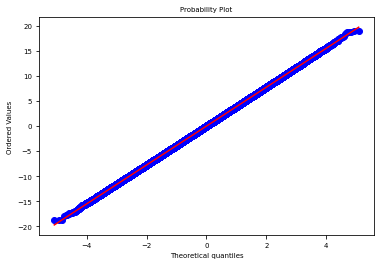

In [380]:
import pylab 
import scipy.stats as stats
measurs = Iest_vecs - np.mean(Iest_vecs, axis=1, keepdims=True)
measurements = measurs[4,:,-1,:,:].ravel()#np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(measurements, dist='norm', plot=pylab)
pylab.show()

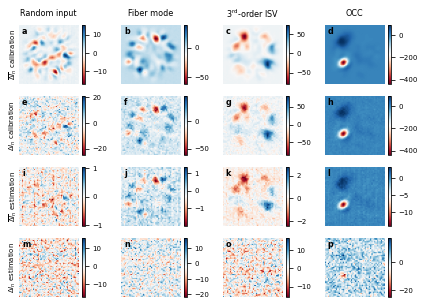

In [544]:
ind_amp = 2#2
ind_amp2 = -1
ind_der_pm = 3
fig, axs = plt.subplots(4,4, figsize=(7,5))
Idiffs_amps = (Iest_vecs[ind_der_0+ind_der_pm,:,ind_amp]-
               Iest_vecs[ind_der_0-ind_der_pm,:,ind_amp])
Idiffs_ampsl = (Iest_vecs[ind_der_0+1,:,ind_amp2]-
               Iest_vecs[ind_der_0,:,ind_amp2])
# Idiffs_amps = (np.mean(Iest_vecs[ind_der_0+ind_der_pm,:], axis=0)-
#                np.mean(Iest_vecs[ind_der_0-ind_der_pm,:], axis=0))
# ylbls = ['$\overline{\Delta I}_n$ at 100%','$\overline{\Delta I}_n$ at 4%']
ylbls = ['$\overline{\Delta I}_n$ calibration', '$\Delta I_n$ calibration',
         '$\overline{\Delta I}_n$ estimation', '$\Delta I_n$ estimation']
labels = ['Random input', 'Fiber mode', '3${}^\mathregular{rd}$-order ISV', 'OCC']
nb_lb = [['a','b','c','d'],['e','f','g','h'],['i','j','k','l']
,['m','n','o','p']]

for ind_f in range(4):
    intp = plot_field(np.mean(Idiffs_amps[:,ind_f], axis=0), axs[0,ind_f],
                        cmap='RdBu')
    fig.colorbar(intp, ax= axs[0,ind_f])

    intp = plot_field(Idiffs_amps[0,ind_f], axs[1,ind_f],
                        cmap='RdBu')
    fig.colorbar(intp, ax= axs[1,ind_f])

    intl = plot_field(np.mean(Idiffs_ampsl[:,ind_f], axis=0), axs[2,ind_f],
                        cmap='RdBu')
    fig.colorbar(intl, ax= axs[2,ind_f])
    
    intl = plot_field(Idiffs_ampsl[0,ind_f], axs[3,ind_f],
                        cmap='RdBu')
    fig.colorbar(intl, ax= axs[3,ind_f])
    
    axs[0,ind_f].text(0.5,1.2, labels[ind_f],transform = axs[0,ind_f].transAxes,
     horizontalalignment='center', fontsize=MEDIUM_SIZE,
     verticalalignment='center', rotation=0)
    for i2 in range(4):
        axs[i2,ind_f].text(0.05,0.85,nb_lb[i2][ind_f], transform=axs[i2,ind_f].transAxes, color='black', fontweight='bold')
        if ind_f==0:
            axs[i2,ind_f].text(-0.1,0.5, ylbls[i2],transform = axs[i2,ind_f].transAxes,
                horizontalalignment='center', fontsize=SMALL_SIZE,
                verticalalignment='center', rotation=90)
for ax in axs.ravel():
    ax.axis('off')


plt.savefig(os.path.join(fig_path,'IchgVpixI.pdf'),bbox_inches='tight')

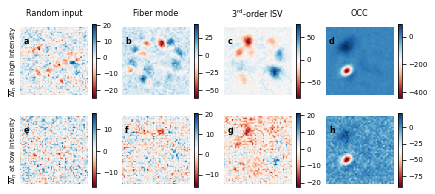

In [355]:
ind_amp = 2
ind_amp2 = -1
fig, axs = plt.subplots(2,4, figsize=(7,3))
Idiffs_amps = (Iest_vecs[ind_der_0+ind_der_pm,0]-
               Iest_vecs[ind_der_0-ind_der_pm,0])
# Idiffs_amps = (np.mean(Iest_vecs[ind_der_0+ind_der_pm,:], axis=0)-
#                np.mean(Iest_vecs[ind_der_0-ind_der_pm,:], axis=0))
# ylbls = ['$\overline{\Delta I}_n$ at 100%','$\overline{\Delta I}_n$ at 4%']
ylbls = ['$\overline{\Delta I}_n$ at high intensity',
         '$\overline{\Delta I}_n$ at low intensity']
labels = ['Random input', 'Fiber mode', '3${}^\mathregular{rd}$-order ISV', 'OCC']
nb_lb = [['a','b','c','d'],['e','f','g','h']]

for ind_f in range(4):
    intp = plot_field(Idiffs_amps[ind_amp,ind_f], axs[0,ind_f],
                        cmap='RdBu')
    
    intl = plot_field(Idiffs_amps[ind_amp2,ind_f], axs[1,ind_f],
                        cmap='RdBu')
    fig.colorbar(intp, ax= axs[0,ind_f])
    fig.colorbar(intl, ax= axs[1,ind_f])
    
    
    axs[0,ind_f].text(0.5,1.2, labels[ind_f],transform = axs[0,ind_f].transAxes,
     horizontalalignment='center', fontsize=MEDIUM_SIZE,
     verticalalignment='center', rotation=0)
    for i2 in range(2):
        axs[i2,ind_f].text(0.05,0.75,nb_lb[i2][ind_f], transform=axs[i2,ind_f].transAxes, color='black', fontweight='bold')
        if ind_f==0:
            axs[i2,ind_f].text(-0.1,0.5, ylbls[i2],transform = axs[i2,ind_f].transAxes,
                horizontalalignment='center', fontsize=SMALL_SIZE,
                verticalalignment='center', rotation=90)
for ax in axs.ravel():
    ax.axis('off')


In [394]:
Idark = np.load(os.path.join(data_path,'dark_imgs.npy'))

In [396]:
dark_bkgd = np.mean(Idark,axis=0)

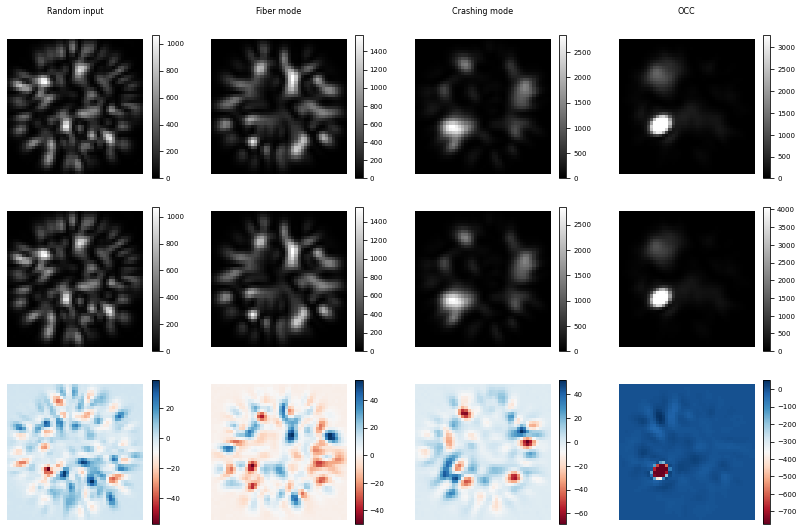

In [409]:
zf=2
ind_def= 4
ind_amp = 0
ind_amp2 = 1
meansI = np.mean(Iest_vecs, axis=1)
stdI = np.std(Iest_vecs, axis=1)
fig, axs = plt.subplots(3,4, figsize=(zf*7.,zf*4.5))
nb_lb = [['a','b','c','d'],['e','f','g','h'],['i','j','k','l']
,['m','n','o','p']]
ylbls = ['$\overline{I}_n$ at 100%','$\sigma_n$ at 100%','$\overline{I}_n$ at 4%','$\sigma_n$ at 4%']

labels = ['Random input', 'Fiber mode', 'Crashing mode', 'OCC']

sc_imgs =(int_scs[ind_amp2]/int_scs[ind_amp])[0,0]

for ind_f in range(4):
    ints1 = sc_imgs*(meansI[ind_def,ind_amp,ind_f]-1*dark_bkgd)
    intp = plot_field(ints1, axs[0,ind_f],
                      cmap=cmap_int,vmin=0)
    fig.colorbar(intp, ax= axs[0,ind_f])

    ints2 = meansI[ind_def,ind_amp2,ind_f]-1*dark_bkgd
    intp = plot_field(ints2, axs[1,ind_f],
                      cmap=cmap_int,vmin=0)
    fig.colorbar(intp, ax= axs[1,ind_f])
    
    intp = plot_field(ints1-ints2, axs[2,ind_f],
                      cmap='RdBu')
    fig.colorbar(intp, ax= axs[2,ind_f])

    axs[0,ind_f].text(0.5,1.2, labels[ind_f],transform = axs[0,ind_f].transAxes,
     horizontalalignment='center', fontsize=MEDIUM_SIZE,
     verticalalignment='center', rotation=0)
    # for i2 in range(4):
    #     axs[i2,ind_f].text(0.05,0.75,nb_lb[i2][ind_f], transform=axs[i2,ind_f].transAxes, color='w', fontweight='bold')
    #     if ind_f==0:
    #         axs[i2,ind_f].text(-0.1,0.5, ylbls[i2],transform = axs[i2,ind_f].transAxes,
    #             horizontalalignment='center', fontsize=SMALL_SIZE,
    #             verticalalignment='center', rotation=90)

for ax in axs.ravel():
    ax.axis('off')
